In [39]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration
)
from PIL import Image, ImageOps
import torch
import pandas as pd
import re
import gc
from tqdm import tqdm
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import ast

from test_MLLMs import mllm_testing, run_vlm_evaluation
from making_color_images.model_priors import ModelColorPriors
from making_color_images.plot_variants import collect_variants_for, show_variants_grid

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [2]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
data_folder = WORK / "color-concept-entanglement" / "data"

fruit = data_folder / "fruit"
color_outlines = data_folder / "color_images"

## Load Model

In [3]:
# Set a specific seed for reproducibility
SEED = 42

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 1. Simple Fruit Dataset

In [4]:
# Simple fruit dataset
evaluate_fruit = False
df = pd.read_parquet(fruit/ "fruit_images.parquet")

if evaluate_fruit:
    df_results = run_vlm_evaluation(
        df,
        processor,
        model,
        device,
        mode="both"
    )
    
    display(df_results)
    out_path = fruit / "outline_results.csv"
    df.to_csv(out_path, index=False)
elif (fruit / "outline_results.csv").exists():
    fruit_df = pd.read_csv(fruit / "outline_results.csv")
    display(fruit_df)

,object,image_type,image_path
0,banana,grayscale,data/fruit/banana1.jpeg
1,banana,background,data/fruit/banana1_background.jpeg
2,banana,color,data/fruit/banana1_color.jpeg
3,banana,grayscale,data/fruit/banana2.jpeg
4,banana,background,data/fruit/banana2_background.jpeg
5,banana,color,data/fruit/banana2_color.jpeg
6,blueberry,grayscale,data/fruit/blueberry.jpeg
7,blueberry,background,data/fruit/blueberry_background.jpeg
8,blueberry,color,data/fruit/blueberry_color.jpeg
9,cucumber,grayscale,data/fruit/cucumber.jpeg


## 2. Outline Image Dataset 

In [5]:
df = pd.read_csv(data_folder / "colored_images.csv")
display(df)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['black', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,"['grey', 'black']",brown,car wheel,https://www.shutterstock.com/image-illustratio...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,['green'],red,bullfrog,https://media.istockphoto.com/id/964986066/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
350,"['brown', 'green']",blue,beer bottle,https://c8.alamy.com/comp/2XF01E0/hand-drawn-b...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
351,['green'],purple,parakeet,https://cdn.vectorstock.com/i/1000v/43/67/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
352,['green'],blue,lawn_mower,https://i.etsystatic.com/35917727/r/il/6615c3/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
353,['yellow'],purple,lemon,https://i.pinimg.com/474x/14/b7/8c/14b78c7fe1c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


## 2.1. Query world-knowledge color priors

In [6]:
# Select specific objects for testing
df = pd.read_csv(data_folder / "colored_images.csv")
#df = df[df["object"].isin(["bullfrog", "pig", "king crab", "tick", "Norwegian elkhound", "beets"])]
display(df)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['black', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,"['grey', 'black']",brown,car wheel,https://www.shutterstock.com/image-illustratio...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,['green'],red,bullfrog,https://media.istockphoto.com/id/964986066/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
350,"['brown', 'green']",blue,beer bottle,https://c8.alamy.com/comp/2XF01E0/hand-drawn-b...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
351,['green'],purple,parakeet,https://cdn.vectorstock.com/i/1000v/43/67/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
352,['green'],blue,lawn_mower,https://i.etsystatic.com/35917727/r/il/6615c3/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
353,['yellow'],purple,lemon,https://i.pinimg.com/474x/14/b7/8c/14b78c7fe1c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [10]:
# Initalize ModelColorPriors
priors = ModelColorPriors(
    processor=processor,
    model=model,
    data_folder=data_folder,
    device=device
)

In [ ]:

# Generate new priors
ground_truth_df = priors.get_model_color_priors(df)

Running model color priors:   0%|          | 0/355 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [11]:
# Checkpoint: display the generated priors
ground_truth_df = pd.read_csv(data_folder / "model_color_priors.csv")
display(ground_truth_df[['object', 'correct_answer', 'model_prior_dummy', 'model_prior']])

,object,correct_answer,model_prior_dummy,model_prior
0,Norwegian elkhound,"['grey', 'black']",grey,grey
1,Newfoundland,"['black', 'brown']",black,black
2,lobster,['red'],red,red
3,car wheel,"['grey', 'black']",black,black
4,bullfrog,['green'],green,green
...,...,...,...,...
350,beer bottle,"['brown', 'green']",green,green
351,parakeet,['green'],green,green
352,lawn_mower,['green'],green,green
353,lemon,['yellow'],yellow,yellow


In [12]:
# Analyze dummy vs real
ground_truth_df = priors.analyze_differences(ground_truth_df)

0 rows differ between dummy and real priors.
101 rows where model color prior NOT in ground truth.
Model color priors: ['grey' 'black' 'red' 'green' 'yellow' 'orange' 'white' 'brown' 'silver'
 'blue' 'pink' 'purple' 'gold' 'clear']


In [13]:
# Replace correct_answer in main df with model priors
df_updated = priors.replace_correct_answers(df, ground_truth_df)

Excluding colors: ['silver', 'gold', 'white', 'clear']
Updated dataset now has 299 rows.


In [ ]:
# Optional load
# ground_truth_df = priors.load_model_priors()

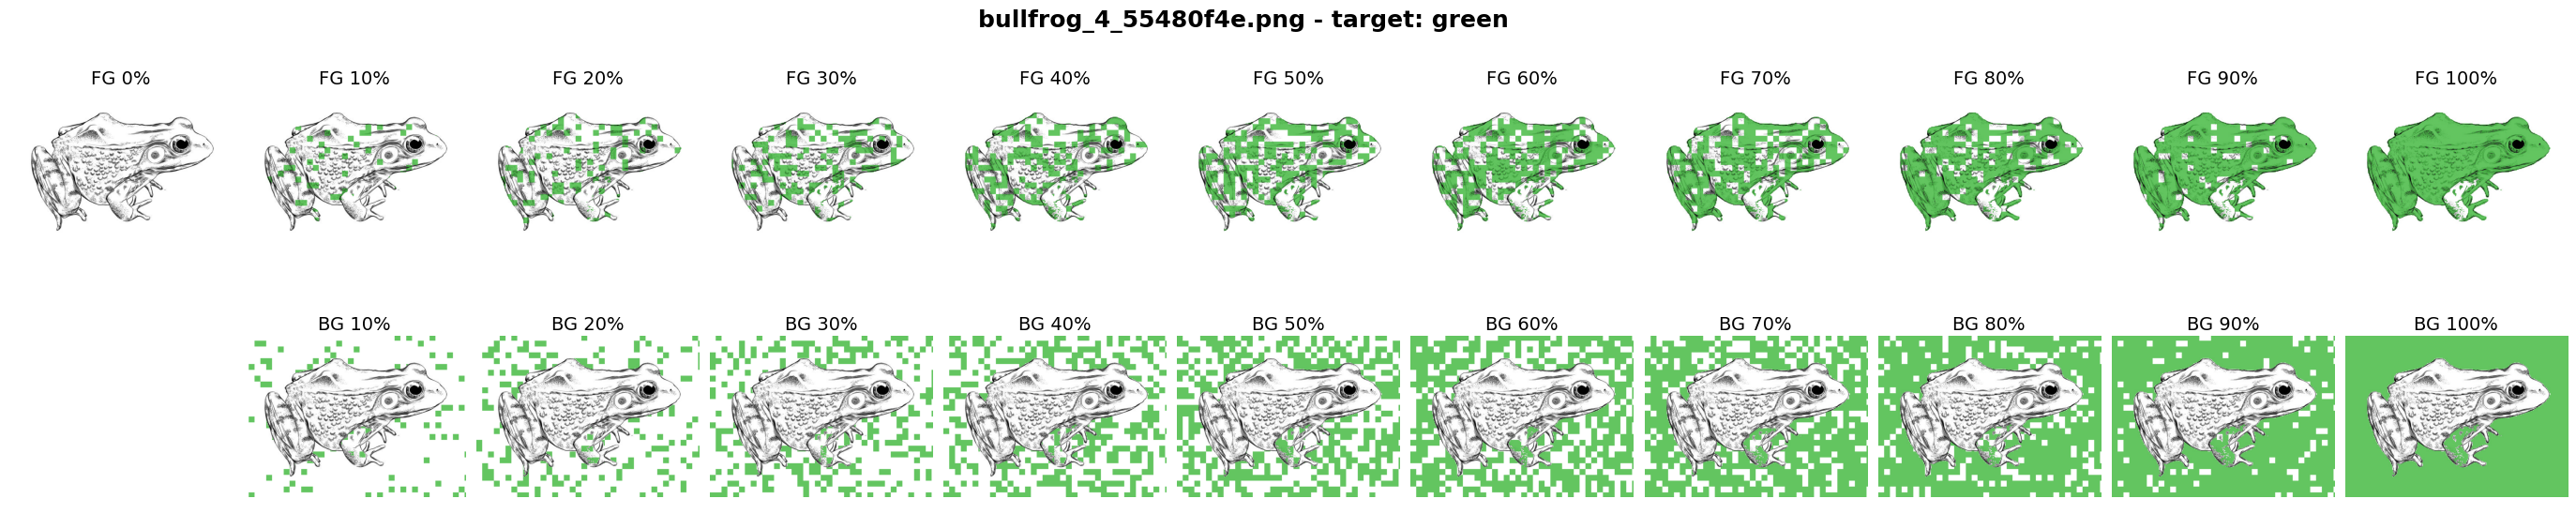

In [38]:
for idx, row in df.head().iterrows():
    target_colors = ast.literal_eval(row['correct_answer'])
    for tcol in target_colors:
        show_variants_grid(row['image_path'], tcol, color_outlines)

In [14]:
df = df[df["object"] == "bullfrog"]

In [32]:
def variant_label(p: Path):
    """
    Create readable labels from variant filenames (FG_###.png / BG_###.png / base).
    """
    name = p.name
    if "FG_" in name:
        m = re.search(r"FG_(\d{3})", name)
        return f"FG {int(m.group(1))}%" if m else "FG"
    elif "BG_" in name:
        m = re.search(r"BG_(\d{3})", name)
        return f"BG {int(m.group(1))}%" if m else "BG"
    else:
        return "white"


# Main evaluation of color outline variants
preds = []

print("Running outline variant evaluation...")

for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating objects"):
    image_path = row["image_path"]
    object_name = row["object"]
    target_colors = ast.literal_eval(row["correct_answer"])

    for target_color in target_colors:
        # Collect all variant image paths for this color
        variants = collect_variants_for(image_path, target_color, out_root=color_outlines)
        if not variants:
            continue

        # Build a dataframe for all variants of this image
        df_variants = pd.DataFrame({
            "image_path": [str(p) for p in variants],
            "image_variant": [variant_label(p) for p in variants],
            "object": [object_name] * len(variants),
            "correct_answer": [target_color] * len(variants)
        })

        # Run both "most" and "this" question types on all variants
        df_eval = run_vlm_evaluation(
            df=df_variants,
            processor=processor,
            model=model,
            device=device,
            batch_size=1,
            mode="both"   
        )
        df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_most", "pred_color_this"]]
        preds.append(df_eval)

        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

pred_color_df = pd.concat(preds, ignore_index=True)

out_path = data_folder / "outline_results.csv"
pred_color_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_color_df.head(10))

Running outline variant evaluation...


Evaluating objects: 100%|██████████| 1/1 [03:20<00:00, 200.47s/it]

Saved combined outline evaluation results to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/outline_results.csv


,object,image_variant,correct_answer,pred_color_most,pred_color_this
0,bullfrog,FG 0%,green,green,grey
1,bullfrog,FG 10%,green,green,green
2,bullfrog,FG 20%,green,green,green
3,bullfrog,FG 30%,green,green,green
4,bullfrog,FG 40%,green,green,green
5,bullfrog,FG 50%,green,green,green
6,bullfrog,FG 60%,green,green,green
7,bullfrog,FG 70%,green,green,green
8,bullfrog,FG 80%,green,green,green
9,bullfrog,FG 90%,green,green,green


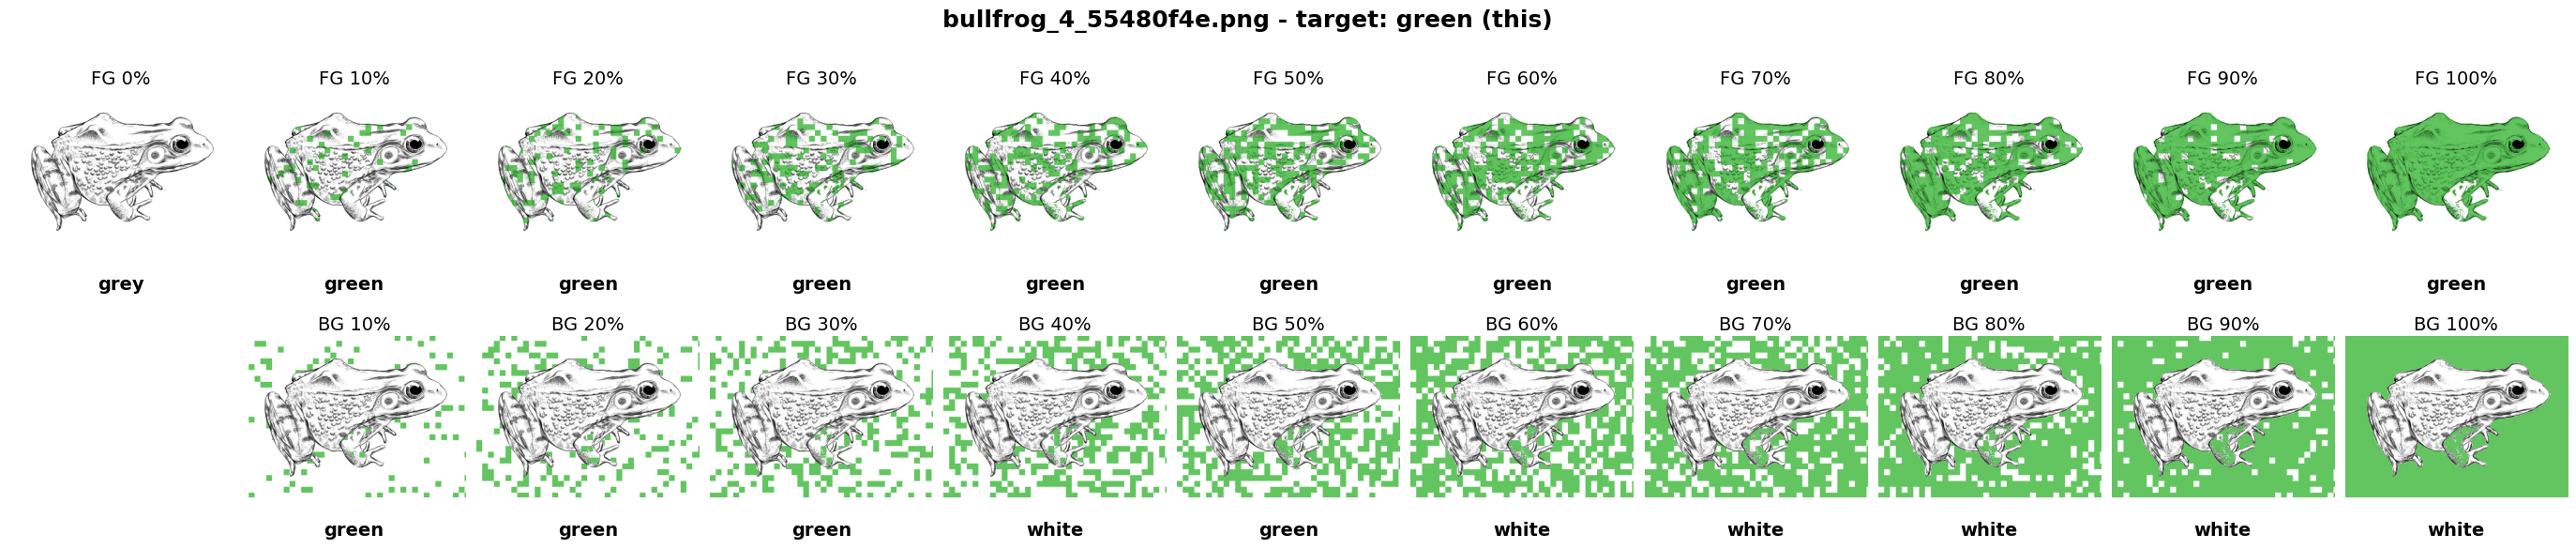

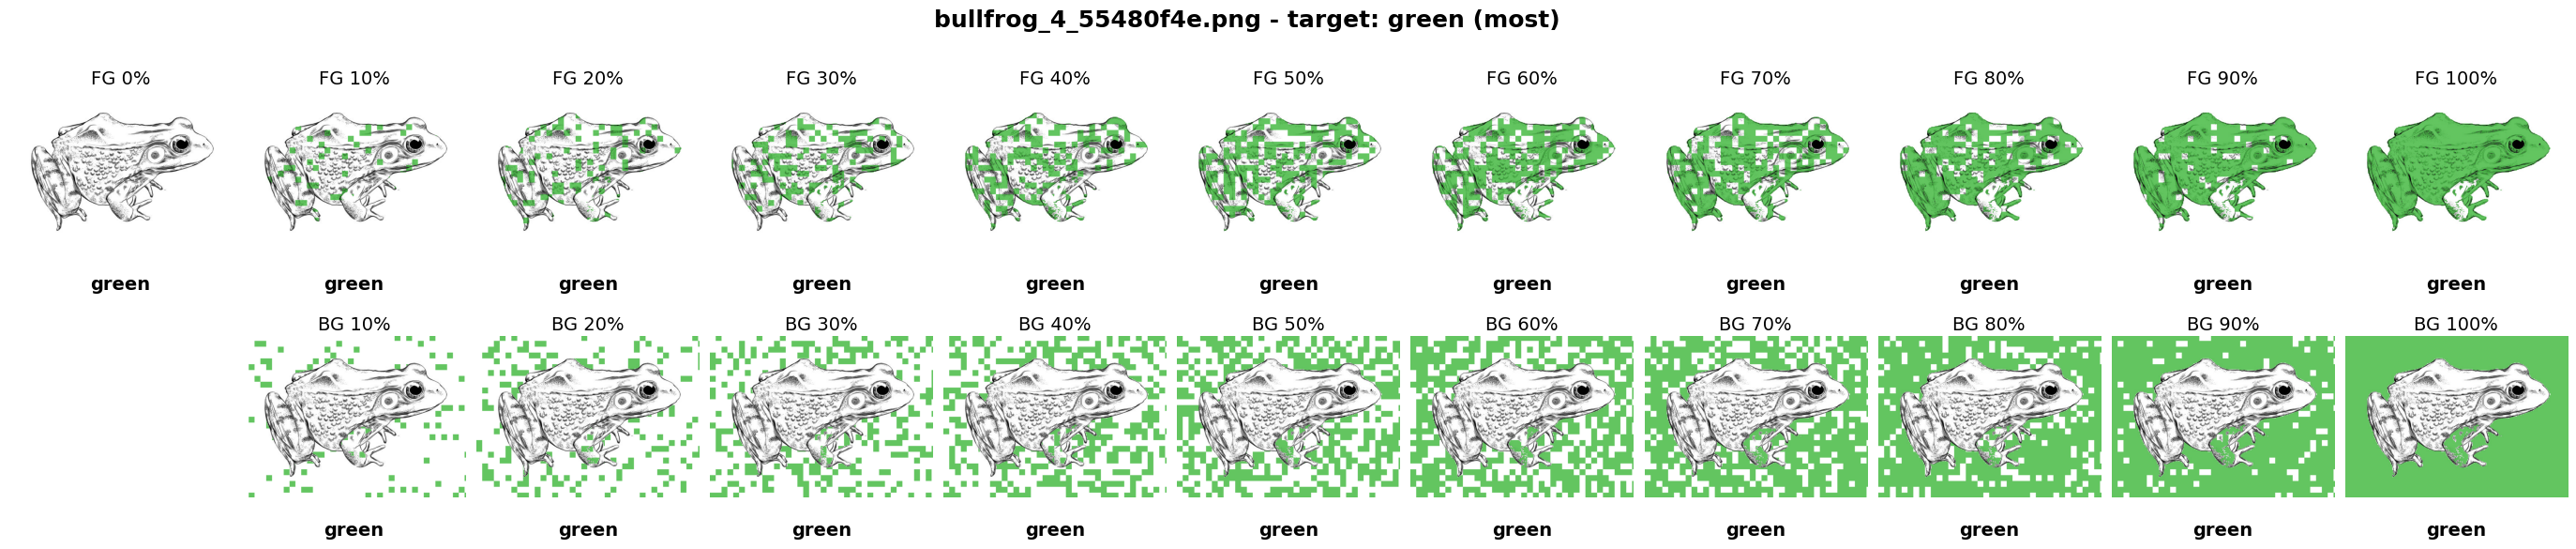

In [37]:
for idx, row in df.head().iterrows():
    target_colors = ast.literal_eval(row['correct_answer'])
    for tcol in target_colors:
        # Show predictions for both question types
        show_variants_grid(row["image_path"], tcol, color_outlines, pred_color_df, question="this")
        show_variants_grid(row["image_path"], tcol, color_outlines, pred_color_df, question="most")